# IMAGE CLASSIFIER PROJECT
The dataset is composed of dog and cat photos provided as a subset of photos from a much larger collection of 3 million manually annotated photos. This data was obtained through a collaboration between Petfinder.com and Microsoft

In [1]:
# MY code here

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import shutil
from PIL import Image
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.models import load_model


2024-09-24 09:31:37.326903: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Visualize the input information

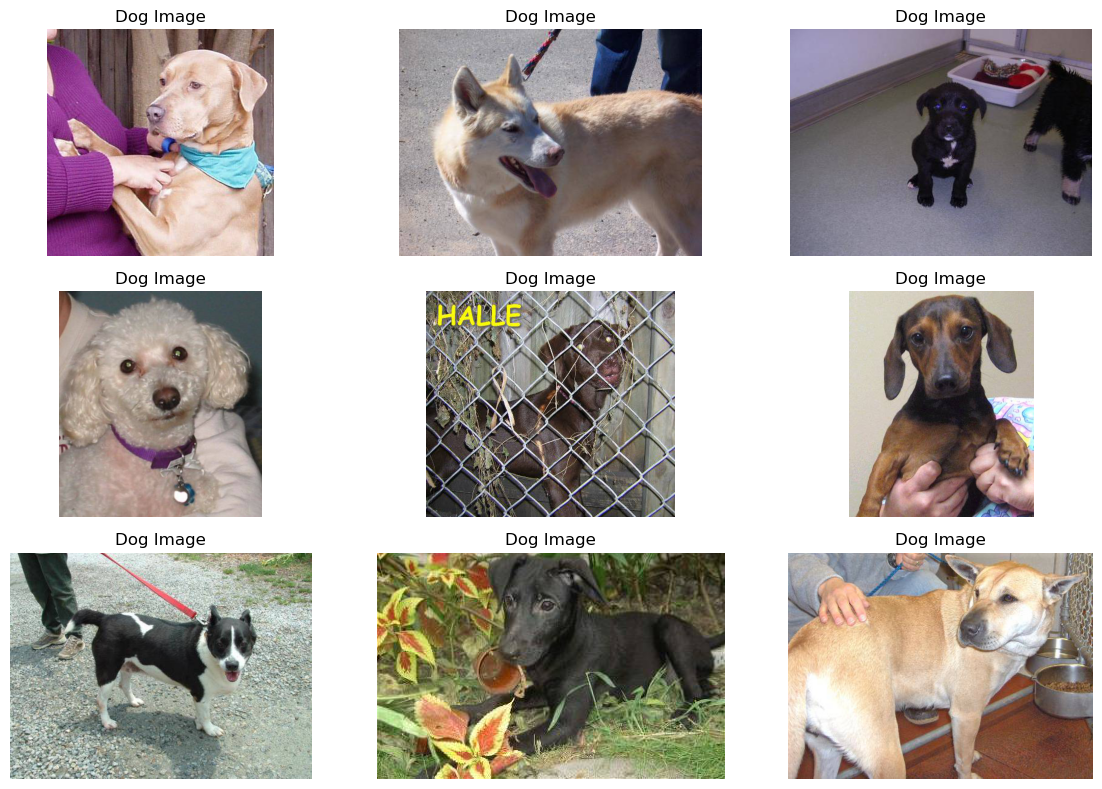

In [4]:
# Ruta al directorio que contiene sus datos de imagen
data_dir = "../data/raw"

# Obtener una lista de todos los nombres de archivos de imágenes de perros
dog_subfolder = os.path.join(data_dir, "perros")

# Obtener una lista de todos los nombres de archivos de imágenes de perros
dog_image_files = os.listdir(dog_subfolder)

# Cargar las nueve primeras imágenes de perros
dog_images = []
for i in range(9):
    img_path = os.path.join(dog_subfolder, dog_image_files[i])
    img = image.load_img(img_path)  # Ajuste target_size según sea necesario
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalice los valores de los píxeles a [0, 1].
    dog_images.append(img_array)

# Cree una única figura para mostrar las nueve imágenes
plt.figure(figsize=(12, 8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(dog_images[i])
    plt.title('Dog Image')
    plt.axis('off')

# Ajustar el diseño
plt.tight_layout()

# Mostrar las imágenes
plt.show()

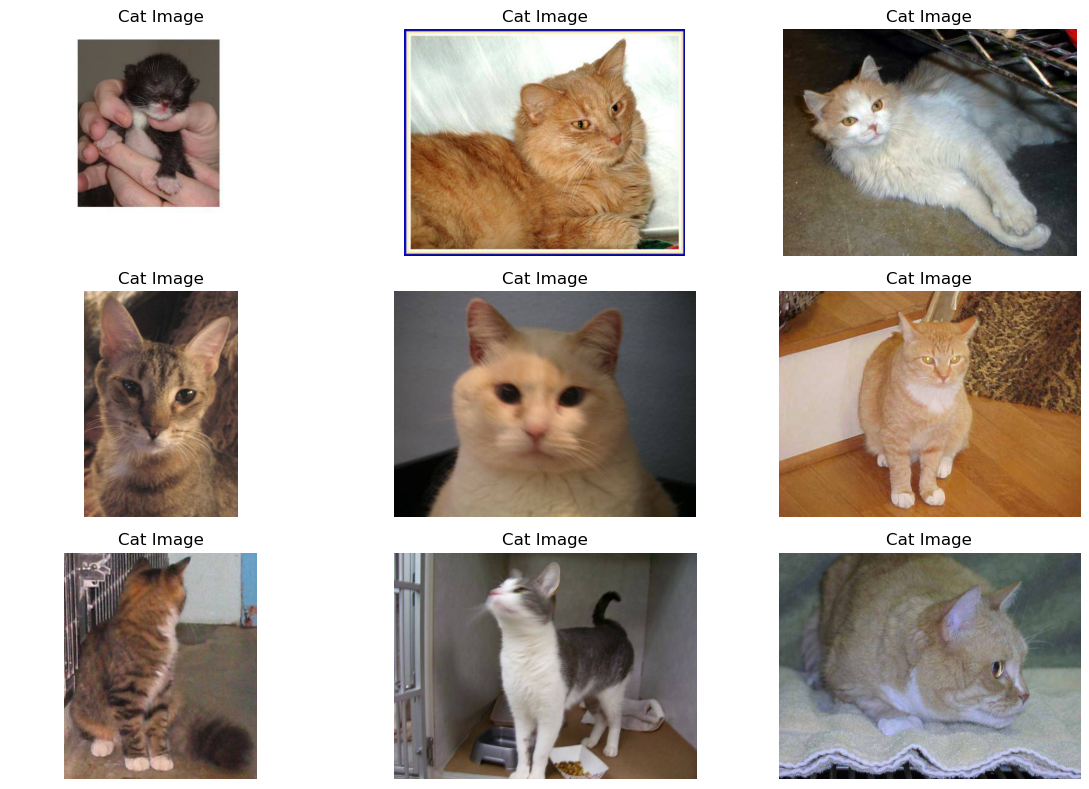

In [5]:

# Ruta al directorio que contiene sus datos de imagen
data_dir = "../data/raw"

# Obtener una lista de todos los nombres de archivos de imagen Cat
cats_subfolder = os.path.join(data_dir, "gatos")

# Obtener una lista de todos los nombres de archivos de imagen Cat
cats_image_files = os.listdir(cats_subfolder)

# Cargar las nueve primeras imágenes de gato
cats_images = []
for i in range(min(9, len(cats_image_files))):  # Limitar a las imágenes de gato disponibles
    img_path = os.path.join(cats_subfolder, cats_image_files[i])
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    cats_images.append(img_array)

# Crear una única figura para mostrar todas las imágenes cat
plt.figure(figsize=(12, 8))

for i in range(len(cats_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cats_images[i])
    plt.title('Cat Image')
    plt.axis('off')

# Ajustar el diseño
plt.tight_layout()

# Mostrar las imágenes
plt.show()

Crear conjuntos de imagenes para train y test

In [8]:
train_dir = "../data/raw"  # Where the initial training data is stored
test_dir = "../data/test"  # New test directory that we will create
image_size = (200, 200)  # Image size


In [13]:
# Function to split images into training and test sets
def split_train_test(train_dir, test_dir, class_name, split_ratio=0.2):
    class_train_dir = os.path.join(train_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)

    # List all images in the training folder
    all_images = os.listdir(class_train_dir)

    # Shuffle and split images
    random.shuffle(all_images)
    split_point = int(len(all_images) * split_ratio)
    test_images = all_images[:split_point]

    # Move test images to test folder
    for img_name in test_images:
        img_path = os.path.join(class_train_dir, img_name)
        shutil.move(img_path, os.path.join(class_test_dir, img_name))

# Split the dataset for 'gatos' and 'perros'
split_train_test(train_dir, test_dir, "gatos", split_ratio=0.2)  # Moving 20% to test
split_train_test(train_dir, test_dir, "perros", split_ratio=0.2)

# Initialize Data Generators
datagentrain = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

datagentest = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

# Generate training data
train_data = datagentrain.flow_from_directory(
    train_dir,
    target_size=image_size,
    classes=["gatos", "perros"],  # Class names must match folder names
    batch_size=32,
    shuffle=True
)

# Generate test data
test_data = datagentest.flow_from_directory(
    test_dir,  # This should contain 'gatos' and 'perros'
    target_size=image_size,
    classes=["gatos", "perros"],  # Same class names for consistency
    batch_size=32,
    shuffle=False  # No need to shuffle test data
)

Found 5000 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


In [18]:
# Print out some data from the generator
for x, y in train_data:
    print("Train data shape:", x.shape, "Label shape:", y.shape)
    break  # Remove this line if you want to see more batches
    
for x, y in test_data:
    print("Test data shape:", x.shape, "Label shape:", y.shape)
    break  # Remove this line if you want to see more batches

Train data shape: (32, 200, 200, 3) Label shape: (32, 2)
Test data shape: (32, 200, 200, 3) Label shape: (32, 2)


In [20]:
model = Sequential()
model.add(Conv2D(input_shape = (200,200,3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))

# Mover los datos por las capas densas
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [22]:
# Training the model
model.fit(train_data, epochs=1, validation_data=test_data)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 5596s 36s/step - accuracy: 0.4966 - loss: 0.7830 - val_accuracy: 0.5000 - val_loss: 0.6932


In [23]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 310s 8s/step - accuracy: 0.8240 - loss: 0.6859
Test Loss: 0.6932114362716675, Test Accuracy: 0.5


In [24]:
# Guardado de modelo

model.save("gatos_y_perros.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
Predicción de salida: [[0.50565743 0.49434257]]
La imagen ../data/test/gatos/cat.40.jpg es un gato.


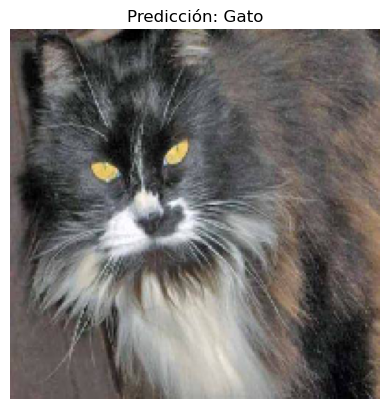

In [28]:
# Ruta de la imagen de prueba
image_path = '../data/test/gatos/cat.40.jpg'  

# Cargar la imagen y preprocesarla
img = image.load_img(image_path, target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalizar la imagen

# Cargar el modelo entrenado desde el archivo
model = load_model('../models/gatos_y_perros.keras')  # Update this path as necessary

# Hacer la predicción
output = model.predict(img_array)
print("Predicción de salida:", output)

# Interpretar la predicción
predicted_class = np.argmax(output, axis=1)[0]  # Obtener la clase con mayor probabilidad
if predicted_class == 0:
    print(f'La imagen {image_path} es un gato.')
else:
    print(f'La imagen {image_path} es un perro.')

# Mostrar la imagen y la predicción
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.title(f'Predicción: {"Gato" if predicted_class == 0 else "Perro"}')
plt.show()